## TODO

conda remove keras = done

pip install tensorflow  = todo


pip install keras = todo

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import math

import xgboost
from sklearn import svm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score,accuracy_score

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LeakyReLU,PReLU,ELU
from keras.layers import Dropout
from keras import backend as K




pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 100)


Using TensorFlow backend.


### FUNCTIONS

In [18]:
## Plotting and general functions

'''
@params:
corr = correlation matrix that you get from df.corr()
fig_size_x : int = figure size width
fig_size_y : int = figure size height

@returns:
    colored correlation matrix. just print the return value
'''

def GetCorrelation(corr,fig_size_x=15,fig_size_y=15):
    corrmat = df.corr()
    f, ax = plt.subplots(figsize=(fig_size_x, fig_size_y))
    sns.heatmap(corrmat, square=True);


    
#Checking the relationships between variables and saleprice 
def Scatter_plot(var,targetVariable="SalePrice"):
    data = pd.concat([df[targetVariable],df[var]],axis=1)
    data.plot.scatter(x=var,y=targetVariable)

def Box_plot(var,targetVariable="SalePrice"):
    plt.figure(figsize=(8,6))
    sns.boxplot(y=targetVariable,x=var,data=df)


def Cat_plot(var,targetVariable="SalePrice"):
    plt.figure(figsize=(8,6))
    sns.catplot(y=targetVariable,x=var,data=df)
    
"""
@params:
    df=dataframe
    targetVariable = Target variable
    numberOfColumns = number of values against targetVariable should be compared with (top k variables with highest correlation)
    largestCorrelation : true if values with largest corrleation is wanted and false otherwise
"""
def getTopCorrelationColumnsNames(df, targetVariable, numberOfColumns, largestCorrelation):
    corrmat = df.corr()
    if largestCorrelation==True:
        return corrmat.nlargest(numberOfColumns, targetVariable)[targetVariable].index
    else:
        return corrmat.nsmallest(numberOfColumns, targetVariable)[targetVariable].index
    
"""
@param: 
    df=dataframe
    numberOfColumns = number of values against targetVariable should be compared with (top k variables with highest correlation)
    targetVariable = Target variable
@returns:
    seaborn heatmap
"""

def HeatmapWithCorrelationValues(df, targetVariable, numberOfColumns=10, largestCorrelation=True):
    cols = getTopCorrelationColumnsNames(df,targetVariable,numberOfColumns,largestCorrelation=largestCorrelation)
    cm = np.corrcoef(df[cols].values.T)
    sns.set(font_scale=1.25)
    f, ax = plt.subplots(figsize=(numberOfColumns*2, numberOfColumns*0.5))

    hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': math.ceil(numberOfColumns/1.5)}, yticklabels=cols.values, xticklabels=cols.values)
    plt.show()


'''
@params:
    df = dataframe
@returns:
    names and total null values in the column and percentage of column thats null
'''
def getNullStats(df):
    NumberOfColumnsWithNullvalues = df.columns[df.isna().any()].size
    percent = (df.isnull().sum().sort_values(ascending=False).head(NumberOfColumnsWithNullvalues)/df.shape[0])*100
    total = df.isnull().sum().sort_values(ascending=False).head(NumberOfColumnsWithNullvalues)
    dataType =  df.isnull().sum().sort_values(ascending=False).head(NumberOfColumnsWithNullvalues)
    return NumberOfColumnsWithNullvalues, pd.concat([total,percent],axis=1,keys = ['Total Null Values','Null Percentage'])


'''
@params:
 missingData : dataframe = dataframe with column name and number of null values in that column (under "Total Null Values" column in missingData dataframe)
 df : dataframe = dataframe whose columns you want to remove
 MinimumThreshold : int = minimum acceptable value for missing data's 'Total Null Values'. Any column having value bigger than threshold will be removed
@returns:
 shortened dataframe
'''
def RemoveColumnsFromData_ForCorrelationThreshold(missingData,df,MinimumThreshold):
    return df.drop( (missingData[missingData['Total Null Values']>MinimumThreshold]) .index, 1)   # >1 because we dont want to delete Electirc feature completely


In [3]:
df = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

In [4]:
print(df.shape)
print(df.columns)

df.head(1)

(1460, 81)
Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500


count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


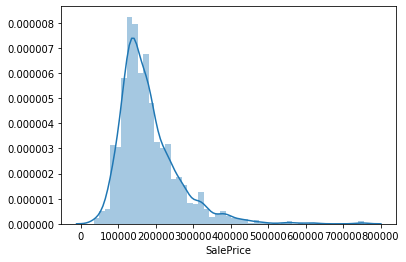

In [5]:
#histogram
# so it shows that most saleprices are around 50,000 to 250,000 .
# but  histogram has long tails (positively skewed) so some properties with really high sale price compared to avg sale price

print(df["SalePrice"].describe())
sns.distplot(df["SalePrice"])      # for histogram


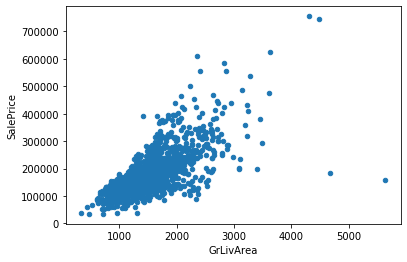

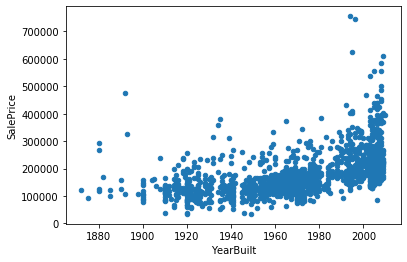

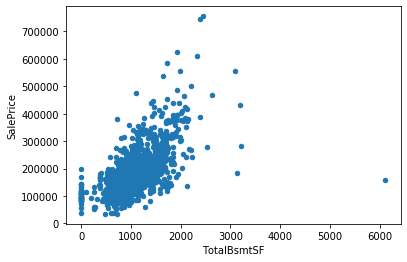

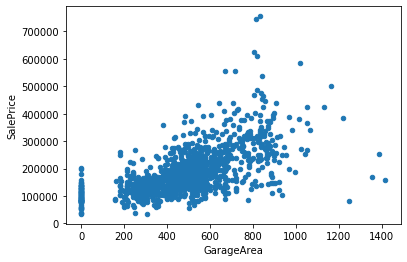

In [6]:
# Drawing Scatter plot of numerical (non categorical) values with high expectations: 
# GrLivArea , YearBuilt , TotalBsmtSF , GarageArea

Scatter_plot("GrLivArea")  # strongly linear 
Scatter_plot("YearBuilt")  # kind of obvious, as year increase, prices increase
Scatter_plot("TotalBsmtSF") #not strongly linear for small basement area but then after that its linear
Scatter_plot("GarageArea")  #weakly 


In [7]:
# for GrLivArea the right most 2 points are jsut outliers and not following the trend.
# The 3rd last and 4th last are outliers but following the trend. so deleting just the ones which are not follwoing the trend
df.sort_values(by = 'GrLivArea', ascending = False)[:2]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,5644,Unf,0,466,6110,GasA,Ex,Y,SBrkr,4692,950,0,5642,2,0,2,1,3,1,Ex,12,Typ,3,Gd,Attchd,2008.0,Fin,2,1418,TA,TA,Y,214,292,0,0,0,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000
523,524,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,Inside,Gtl,Edwards,PosN,PosN,1Fam,2Story,10,5,2007,2008,Hip,CompShg,CemntBd,CmentBd,Stone,762.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,2260,Unf,0,878,3138,GasA,Ex,Y,SBrkr,3138,1538,0,4676,1,0,3,1,3,1,Ex,11,Typ,1,Gd,BuiltIn,2007.0,Fin,3,884,TA,TA,Y,208,406,0,0,0,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750


In [8]:
# for TotalBsmtSF the right most value is an outlier
df.sort_values(by = 'TotalBsmtSF', ascending = False)[:1]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,5644,Unf,0,466,6110,GasA,Ex,Y,SBrkr,4692,950,0,5642,2,0,2,1,3,1,Ex,12,Typ,3,Gd,Attchd,2008.0,Fin,2,1418,TA,TA,Y,214,292,0,0,0,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


In [9]:
# GrLivArea outlier data deleting
df = df.drop(df[df['Id']==1299].index) #for TotalBsmtSF outlier data deleting
df = df.drop(df[df['Id']==524].index)



C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:324: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


<Figure size 576x432 with 0 Axes>

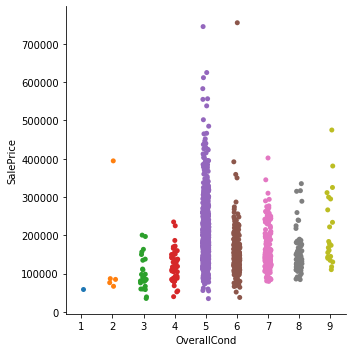

<Figure size 576x432 with 0 Axes>

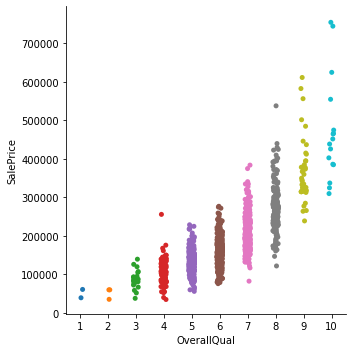

<Figure size 576x432 with 0 Axes>

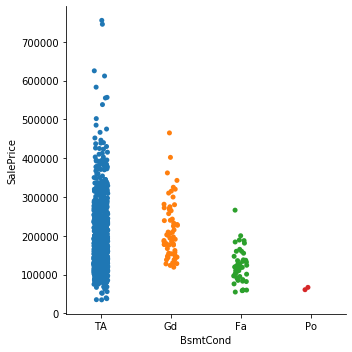

<Figure size 576x432 with 0 Axes>

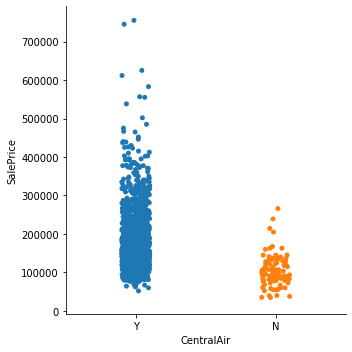

<Figure size 576x432 with 0 Axes>

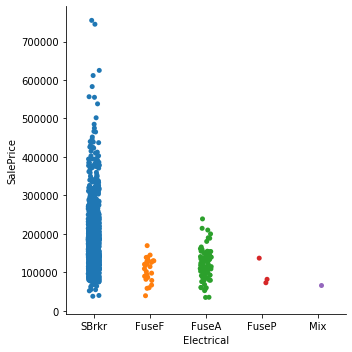

<Figure size 576x432 with 0 Axes>

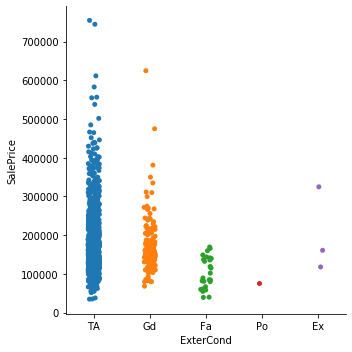

<Figure size 576x432 with 0 Axes>

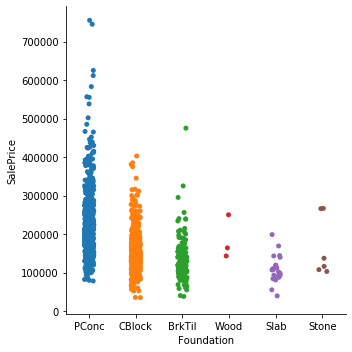

<Figure size 576x432 with 0 Axes>

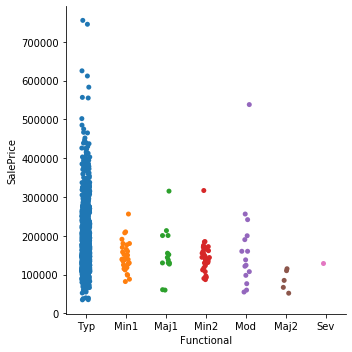

<Figure size 576x432 with 0 Axes>

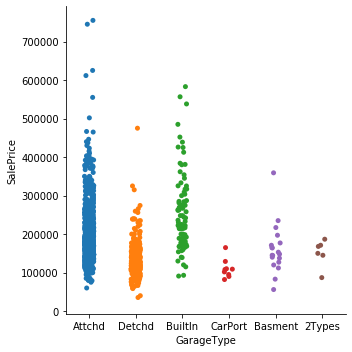

<Figure size 576x432 with 0 Axes>

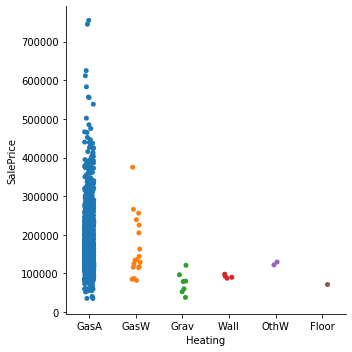

<Figure size 576x432 with 0 Axes>

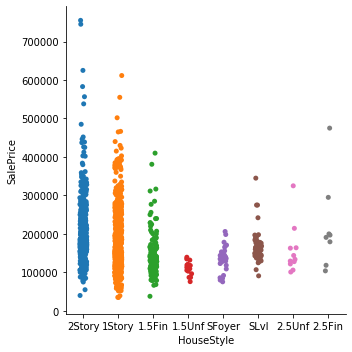

<Figure size 576x432 with 0 Axes>

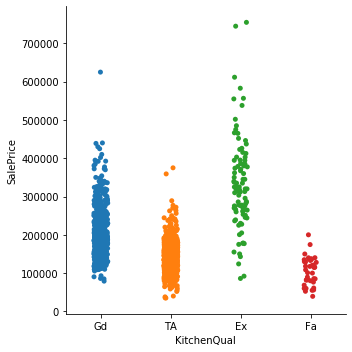

<Figure size 576x432 with 0 Axes>

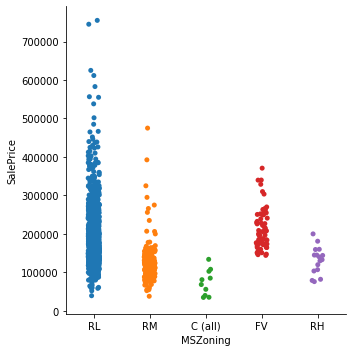

In [10]:
# using Cat plot for categorical High Expectation variables : "OverallCond","OverallQual","BsmtCond","CentralAir",
# "Electrical","ExterCond","Foundation","GarageType","Heating","KitchenQual","MSZoning","Neighborhood"

Cat_plot("OverallCond")
Cat_plot("OverallQual")
Cat_plot("BsmtCond")
Cat_plot("CentralAir")
Cat_plot("Electrical")
Cat_plot("ExterCond")
Cat_plot("Foundation")
Cat_plot("Functional")
Cat_plot("GarageType")
Cat_plot("Heating")
Cat_plot("HouseStyle")
Cat_plot("KitchenQual")
Cat_plot("MSZoning")



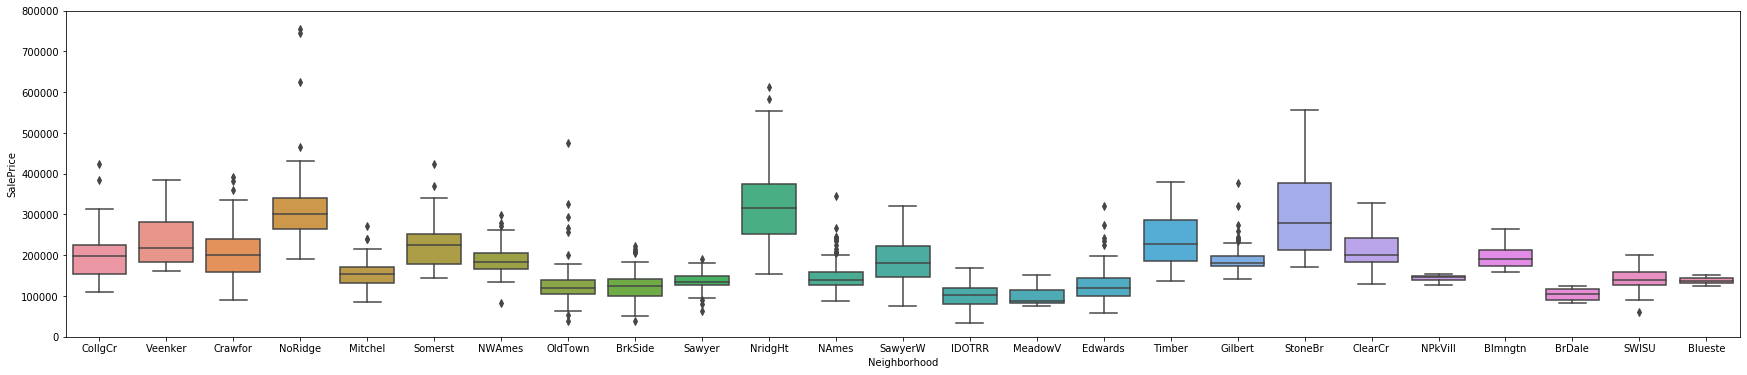

In [11]:
# plotting Neighborhood catplot seperately because it has many categories and need diff figsize
var = 'Neighborhood'
data = pd.concat([df['SalePrice'], df[var]], axis=1)
f, ax = plt.subplots(figsize=(30, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

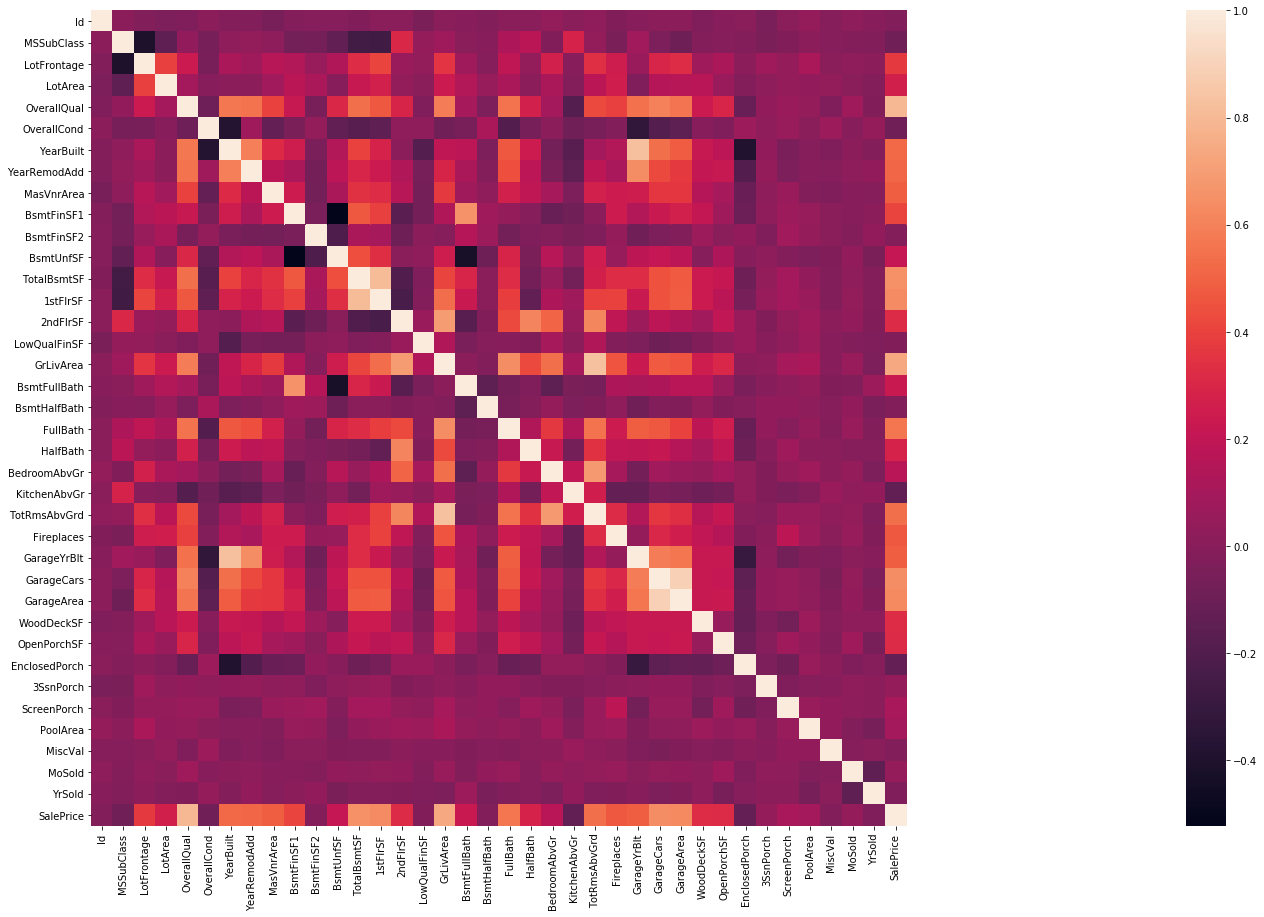

In [12]:
#correlation matrix

GetCorrelation(df,100,15)

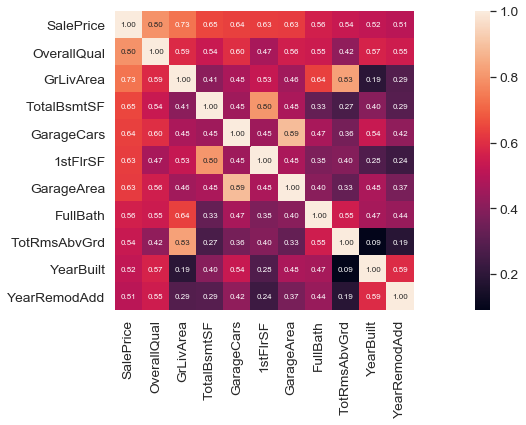

In [13]:
#Finding top 10 features corelated to SalePrice
HeatmapWithCorrelationValues(df=df,targetVariable="SalePrice", numberOfColumns=11, largestCorrelation=True) #11 because i want first 10 except sale price

### Handling Null data

In [14]:

NumberOfColumnsWithNullvalues , missingData = getNullStats(df)

print(NumberOfColumnsWithNullvalues)
missingData

19


,Total Null Values,Null Percentage
PoolQC,1452,99.588477
MiscFeature,1404,96.296296
Alley,1367,93.758573
Fence,1177,80.727023
FireplaceQu,690,47.325103
LotFrontage,259,17.764060
GarageCond,81,5.555556
GarageType,81,5.555556
GarageYrBlt,81,5.555556
GarageFinish,81,5.555556



So 19 columns have null values. 5 of them have very high percentage of null values while 6th has moderate and then others have to investigated.
so use to function made above HeatmapWithCorrelationValues for lowest correaltion values.


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:324: RuntimeWarning: More than 20

<Figure size 576x432 with 0 Axes>

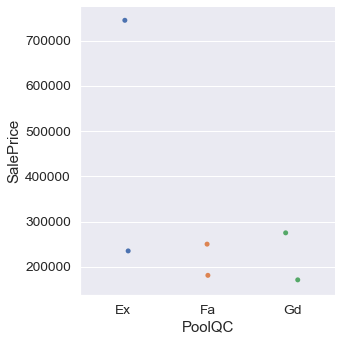

<Figure size 576x432 with 0 Axes>

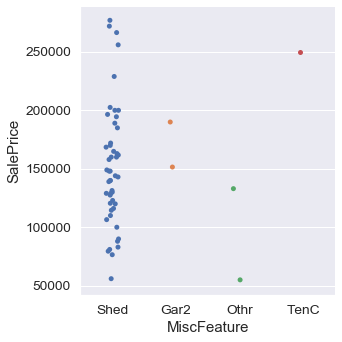

<Figure size 576x432 with 0 Axes>

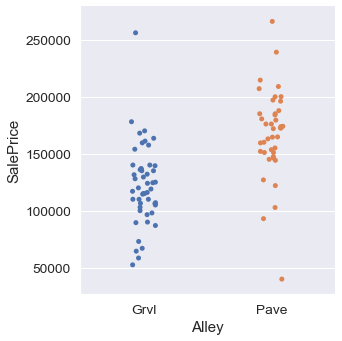

<Figure size 576x432 with 0 Axes>

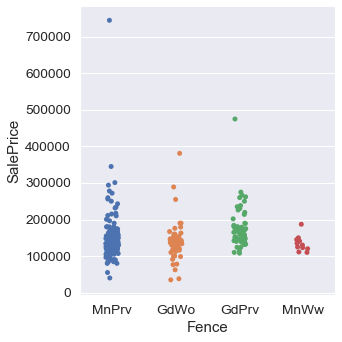

<Figure size 576x432 with 0 Axes>

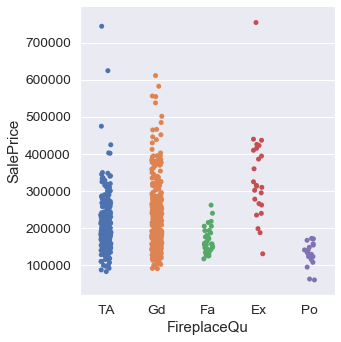

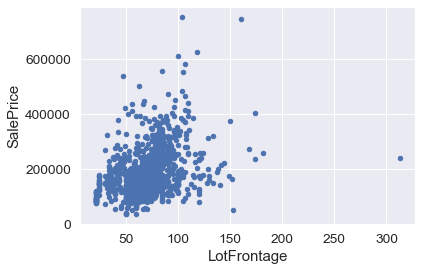

<Figure size 576x432 with 0 Axes>

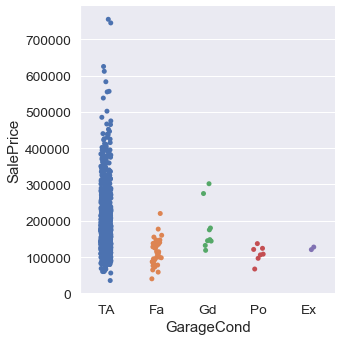

<Figure size 576x432 with 0 Axes>

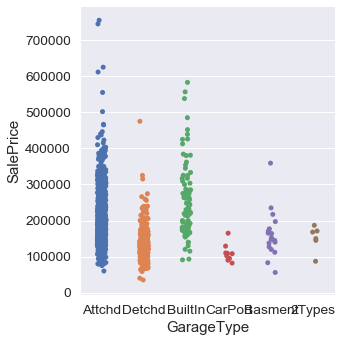

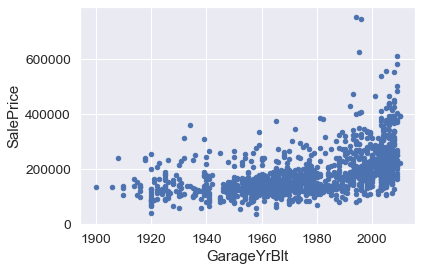

<Figure size 576x432 with 0 Axes>

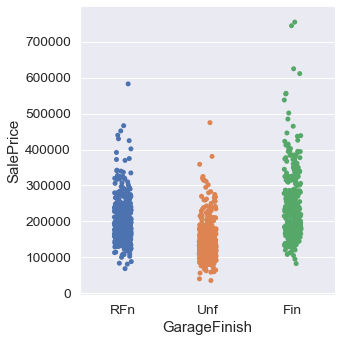

<Figure size 576x432 with 0 Axes>

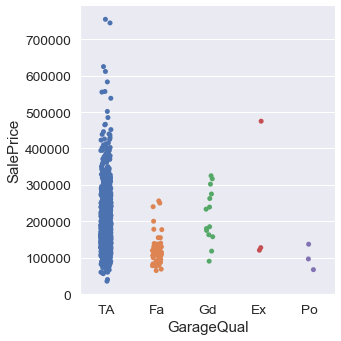

<Figure size 576x432 with 0 Axes>

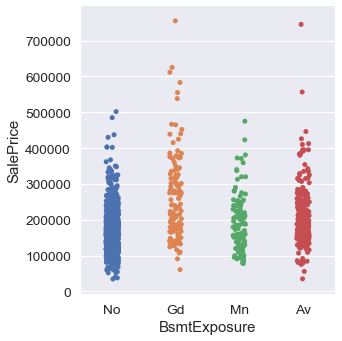

<Figure size 576x432 with 0 Axes>

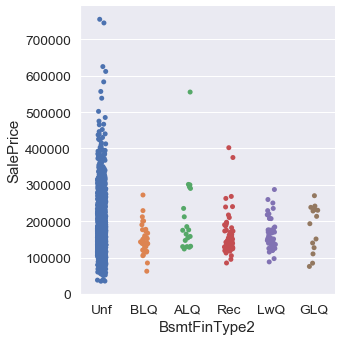

<Figure size 576x432 with 0 Axes>

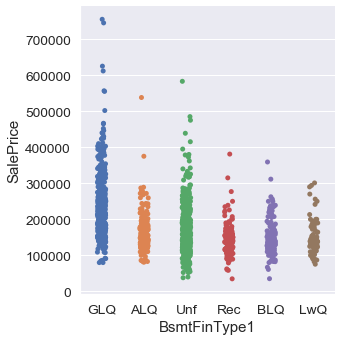

<Figure size 576x432 with 0 Axes>

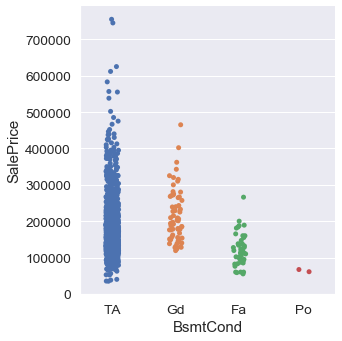

<Figure size 576x432 with 0 Axes>

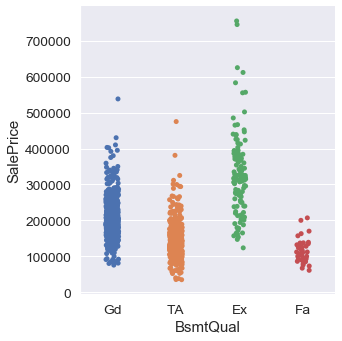

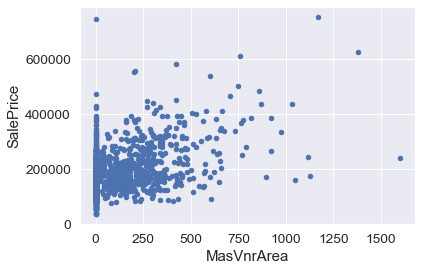

<Figure size 576x432 with 0 Axes>

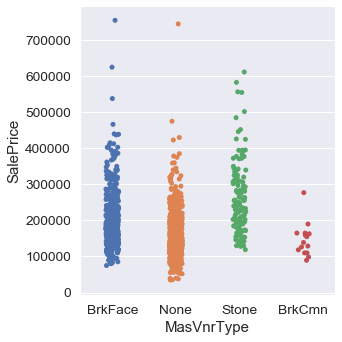

<Figure size 576x432 with 0 Axes>

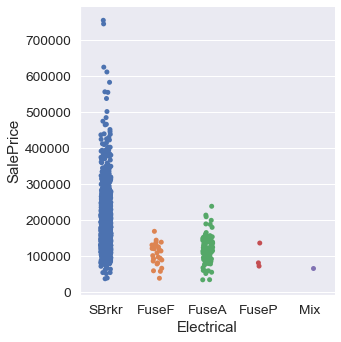

In [15]:
#scatter and cat plots for columns in table variable 
# plots are sorted from the most null values features to least null values features
for i in missingData.index:
    if df[i].dtype==np.object:
        Cat_plot(i)
    else:
        Scatter_plot(i)

# None of the features have good plot (except eletric or some garage variables). we can just drop them

###### dropping 18 columns

In [19]:
#To handle missing data, we'll delete all the variables with missing data, except the variable 'Electrical'. 
# In 'Electrical' we'll just delete the observation with missing data.

    
df = RemoveColumnsFromData_ForCorrelationThreshold(missingData=missingData, df=df, MinimumThreshold=1)   # >1 because we dont want to delete Electirc feature completely
df = df.drop( df.loc[df['Electrical'].isnull()].index )
df.isnull().sum().max()  #checking if any more null values are there in the data

0

# TRANSFORMING SKEWED DATA:

###### Good article for transforming skewed data (same dataset):
https://medium.com/@ODSC/transforming-skewed-data-for-machine-learning-90e6cc364b0



Original  skewness :  1.8803628919012763


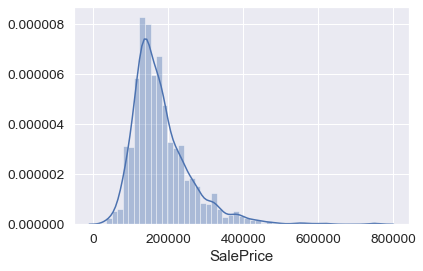

In [20]:
print("Original  skewness : ",df["SalePrice"].skew())

# make histogram to check if dist is normal
sns.distplot(df["SalePrice"])      #positively skewed



((array([-3.30456314, -3.04731426, -2.90425334, ...,  2.90425334,
          3.04731426,  3.30456314]),
  array([ 34900,  35311,  37900, ..., 625000, 745000, 755000], dtype=int64)),
 (74240.99917988207, 180942.13864104328, 0.9320520365889884))

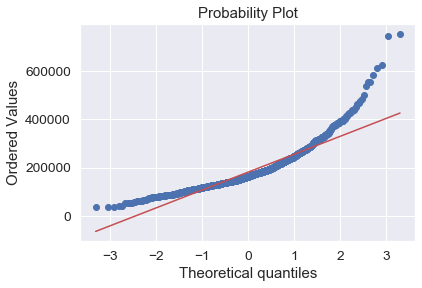

In [21]:
#probability plot.this plot shows how much the data follows a distribtion. 
# default distribution for this function is normal so straighter the line more normal it is
stats.probplot(df['SalePrice'], plot=plt)


In [22]:
# code snippet from medium link mentioned above. This skew function finds the skewness of all continious features.
# (even if you give it the whole dataset it will only return skewness of cont features). 
# .skew calculates Fisher–Pearson standardized moment coefficient.

# The null hypothesis while doing this is that data is normal. 
# so p value should be above 0.5 atleast. less than 0.5 means data has skewness and hence not normal

# If skewness is less than -1 or greater than 1, the distribution is highly skewed. 
# If skewness is between -1 and -0.5 or between 0.5 and 1, the distribution is moderately skewed. 
# If skewness is between -0.5 and 0.5, the distribution is approximately symmetric.

numberOfFeatures = df.dtypes[df.dtypes!='object'].index
skewedFeatures = df[numberOfFeatures].skew().sort_values(ascending=False)
skewness = pd.DataFrame({'Skewness' : skewedFeatures}) 
skewnessTransposed = skewness.T
skewnessTransposed
#simple skewness variable would just take up vertical space 

,MiscVal,PoolArea,LotArea,3SsnPorch,LowQualFinSF,KitchenAbvGr,BsmtFinSF2,ScreenPorch,BsmtHalfBath,EnclosedPorch,OpenPorchSF,SalePrice,WoodDeckSF,MSSubClass,GrLivArea,BsmtUnfSF,1stFlrSF,2ndFlrSF,BsmtFinSF1,OverallCond,HalfBath,TotRmsAbvGrd,Fireplaces,BsmtFullBath,TotalBsmtSF,MoSold,BedroomAbvGr,OverallQual,GarageArea,YrSold,FullBath,Id,GarageCars,YearRemodAdd,YearBuilt
Skewness,24.451726,15.943422,12.56954,10.293487,9.00176,4.483125,4.250256,4.117285,4.098469,3.085809,2.339021,1.880363,1.545377,1.407975,1.010236,0.919946,0.887059,0.814243,0.763964,0.690018,0.682135,0.660943,0.631064,0.589254,0.512456,0.214483,0.212593,0.199555,0.131046,0.095672,0.032573,0.000823,-0.34167,-0.5009,-0.611599


#### So we have to remove the skewness of the data.
#### and why do we care if the data is skewed? Because if the response variable is skewed, then the model will be trained on a much larger number of moderately priced homes, and will be less likely to successfully predict the price for the most expensive houses.

#### There are different types of transformations to remove skewness: square-root, reciprocal, log etc

AxesSubplot(0.125,0.125;0.775x0.755)


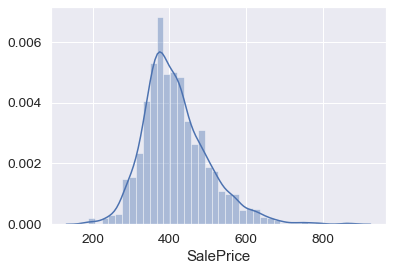

In [23]:
# For salePrice lets try all transformations.

#Square Root transformation
squareRootTransformed = df["SalePrice"]**0.5
print(sns.distplot(squareRootTransformed))

# result : stil looks a little skewed

AxesSubplot(0.125,0.125;0.775x0.755)


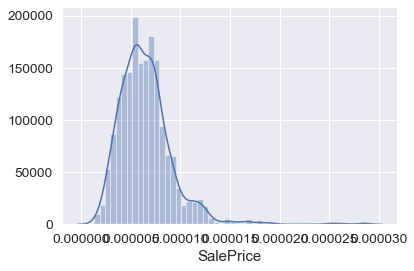

In [24]:
# Reciprocal transformation :
reciprocalTransformed = 1/df["SalePrice"]
print(sns.distplot(reciprocalTransformed))

#result : still skewed a little

AxesSubplot(0.125,0.125;0.775x0.755)


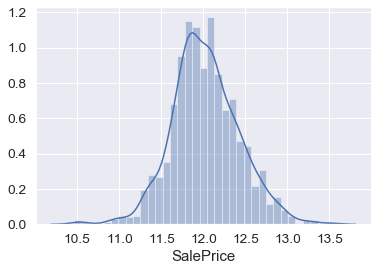

In [25]:
# Log transformation :
logTransformed = np.log(df["SalePrice"])
print(sns.distplot(logTransformed))

#result : still there is some but the best one among others

old skewness :  1.8803628919012763
New skewness :  0.12155100983632659


((array([-3.30456314, -3.04731426, -2.90425334, ...,  2.90425334,
          3.04731426,  3.30456314]),
  array([10.46024211, 10.47194981, 10.54270639, ..., 13.34550693,
         13.5211395 , 13.53447303])),
 (0.3986736383757874, 12.024005414589174, 0.9954027633642684))

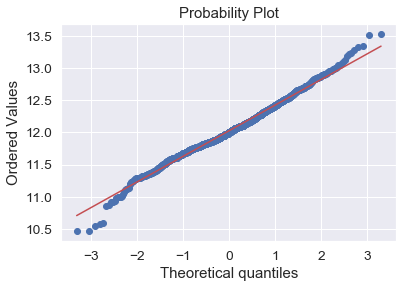

In [26]:
# so since log transformation is best then lets replace salePrice data in dataset with the transformed data
print("old skewness : ",df["SalePrice"].skew())
df["SalePrice"] = np.log(df["SalePrice"])
print("New skewness : ",df["SalePrice"].skew())
stats.probplot(df['SalePrice'], plot=plt)


# If skewness is less than -1 or greater than 1, the distribution is highly skewed. 
# If skewness is between -1 and -0.5 or between 0.5 and 1, the distribution is moderately skewed. 
# If skewness is between -0.5 and 0.5, the distribution is approximately symmetric.

#as we can see , the skewness is much better than before

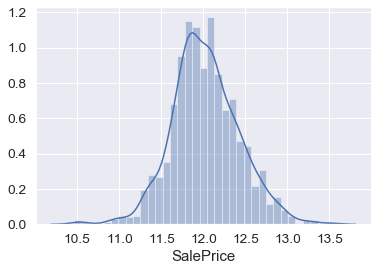

In [27]:

# make histogram to check if dist is normal
sns.distplot(df["SalePrice"])      #positively skewed

## Checking homoscedasticity 

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


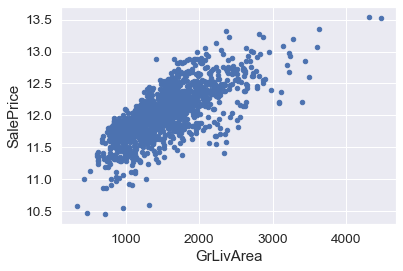

In [28]:
#best way to check is by plotting graph, we are making scatter plot here. variance across the regression line shoul be simillar
Scatter_plot("GrLivArea")

# this shape is not good for homoscedasticity
#so we have to normalize the GrLivArea too now

#### Normalizing GrLivArea

Original  skewness :  1.010236026657094


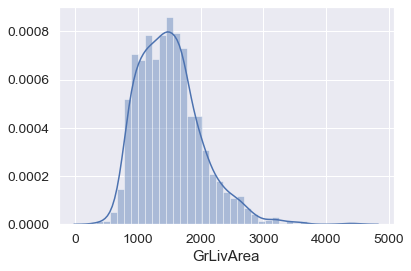

In [29]:
print("Original  skewness : ",df["GrLivArea"].skew())

# make histogram to check if dist is normal
sns.distplot(df["GrLivArea"])      #positively skewed


((array([-3.30456314, -3.04731426, -2.90425334, ...,  2.90425334,
          3.04731426,  3.30456314]),
  array([ 334,  438,  480, ..., 3627, 4316, 4476], dtype=int64)),
 (495.8648796248946, 1510.5456417295816, 0.9744141158065238))

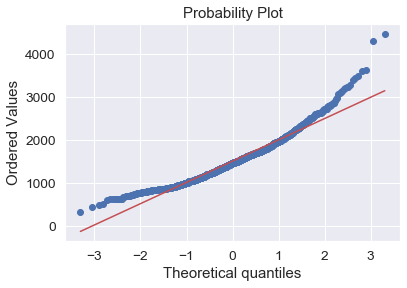

In [30]:
#probability plot.this plot shows how much the data follows a distribtion. 
# default distribution for this function is normal so straighter the line more normal it is
stats.probplot(df['GrLivArea'], plot=plt)
#so the data is skewed and we have to normalize it

old skewness :  1.010236026657094
New skewness :  -0.07195758277146162


((array([-3.30456314, -3.04731426, -2.90425334, ...,  2.90425334,
          3.04731426,  3.30456314]),
  array([5.81114099, 6.08221891, 6.1737861 , ..., 8.19616114, 8.37008433,
         8.40648507])),
 (0.3304288478350053, 7.266041506402603, 0.9981242998055863))

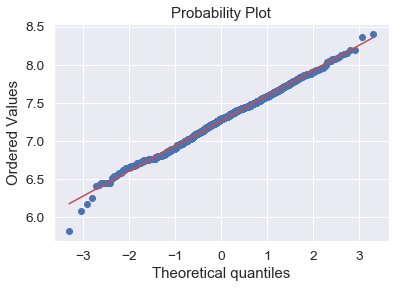

In [31]:
#lets apply log transformation
print("old skewness : ",df["GrLivArea"].skew())
df["GrLivArea"] = np.log(df["GrLivArea"])
print("New skewness : ",df["GrLivArea"].skew())
stats.probplot(df['GrLivArea'], plot=plt)


# If skewness is less than -1 or greater than 1, the distribution is highly skewed. 
# If skewness is between -1 and -0.5 or between 0.5 and 1, the distribution is moderately skewed. 
# If skewness is between -0.5 and 0.5, the distribution is approximately symmetric.

#as we can see , the skewness is much better than before

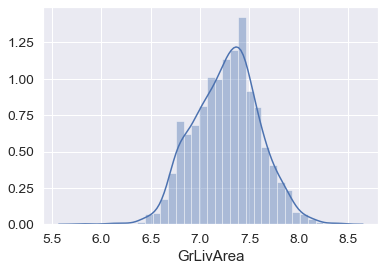

In [32]:
#histogram
sns.distplot(df["GrLivArea"])   # much better symmetric

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


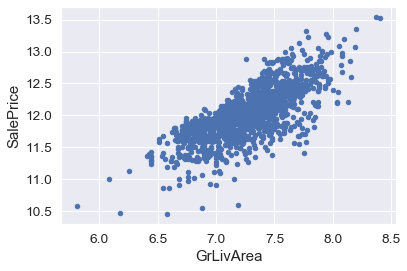

In [33]:
#now check the homoscedasticity
Scatter_plot("GrLivArea") #better homoscedasticity


#### checking homoscedasticity for TotalBsmtSF

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


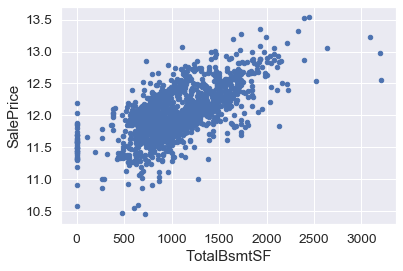

In [34]:
Scatter_plot("TotalBsmtSF")
# So its not that much homoscedasticity but because TotalBsmtSF has values zero so it has to be dealt differently.
# its done in the kaggle kernal https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python/data

##### How to Convert Categorical variables so they can be used for regression??
https://stats.idre.ucla.edu/spss/faq/coding-systems-for-categorical-variables-in-regression-analysis-2/

In [35]:
df2= df.copy(deep=True)

In [36]:
#one way is to use pandas get_dummies(). it returns dataframe with one hot encoded data (converts categorical data to one hot encoding)
df2=pd.get_dummies(df2)


In [37]:
getTopCorrelationColumnsNames(df2,"SalePrice",numberOfColumns=20,largestCorrelation=True)

Index(['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'FullBath', 'YearBuilt', 'YearRemodAdd',
       'TotRmsAbvGrd', 'Foundation_PConc', 'ExterQual_Gd', 'Fireplaces',
       'HeatingQC_Ex', 'KitchenQual_Ex', 'KitchenQual_Gd', 'BsmtFinSF1',
       'ExterQual_Ex', 'Neighborhood_NridgHt'],
      dtype='object')

In [38]:
colsToRetain = getTopCorrelationColumnsNames(df2,"SalePrice",numberOfColumns=20,largestCorrelation=True).tolist()
colsToRetain

['SalePrice',
 'OverallQual',
 'GrLivArea',
 'GarageCars',
 'GarageArea',
 'TotalBsmtSF',
 '1stFlrSF',
 'FullBath',
 'YearBuilt',
 'YearRemodAdd',
 'TotRmsAbvGrd',
 'Foundation_PConc',
 'ExterQual_Gd',
 'Fireplaces',
 'HeatingQC_Ex',
 'KitchenQual_Ex',
 'KitchenQual_Gd',
 'BsmtFinSF1',
 'ExterQual_Ex',
 'Neighborhood_NridgHt']

In [39]:
df2 = df2[colsToRetain]
df2.shape

(1457, 20)

In [40]:
#splitting dependant and independant features

X = df2.drop(['SalePrice'],axis=1)
y = df2['SalePrice']

X_train, X_Valid, y_train, y_Valid = train_test_split(X, y, test_size=0.20, random_state=42)

X_Test = df_test  # df_test doesnt have "SalePrice" column


In [41]:
#model making
n_estimators = [100, 500, 900, 1100, 1500]
max_depth = [2, 3, 5, 10, 15]
booster=['gbtree','gblinear']
learning_rate=[0.05,0.1,0.15,0.20]
min_child_weight=[1,2,3,4]
base_score=[0.25,0.5,0.75,1]

hyperparameter_grid = {
    'n_estimators': n_estimators,
    'max_depth':max_depth,
    'learning_rate':learning_rate,
    'min_child_weight':min_child_weight,
    'booster':booster,
    'base_score':base_score
    }

regressor=xgboost.XGBRegressor(base_score=0.25, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=900,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


#model making
# Set up the random search with 4-fold cross validation
random_cv = RandomizedSearchCV(estimator=regressor,
            param_distributions=hyperparameter_grid,
            cv=5, n_iter=50,
            scoring = 'neg_mean_absolute_error',n_jobs = 4,
            verbose = 5, 
            return_train_score = True,
            random_state=42)

#model fitting
random_cv.fit(X_train,y_train)


#Prediction
y_pred=random_cv.predict(X_Valid)

#model evaluation
rmse = (np.sqrt(mean_squared_error(y_Valid, y_pred)))
r2 = r2_score(y_Valid, y_pred)
adjR2 = 1-(1-r2)*((X_train.shape[0])-1)/((X_train.shape[0])-(X_train.shape[1])-1)


print("RMSE: %f" % rmse)
print("R2 score = ",r2)        # r2 score 
print("Adjusted R2 score = ",adjR2)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    9.2s
[Parallel(n_jobs=4)]: Done 188 tasks      | elapsed:   16.3s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:   19.7s finished


RMSE: 0.147371
R2 score =  0.8748317085834628
Adjusted R2 score =  0.8727546801669439


In [42]:
#XGBoost regression
#model making
#regressor defined above

#model fitting
regressor.fit(X_train,y_train)

#Prediction
y_pred=regressor.predict(X_Valid)

#model evaluation
rmse = (np.sqrt(mean_squared_error(y_Valid, y_pred)))
r2 = r2_score(y_Valid, y_pred)
adjR2 = 1-(1-r2)*((X_train.shape[0])-1)/((X_train.shape[0])-(X_train.shape[1])-1)


print("RMSE: %f" % rmse)
print("R2 score = ",r2)        # r2 score 
print("Adjusted R2 score = ",adjR2)

RMSE: 0.150342
R2 score =  0.8697352763836776
Adjusted R2 score =  0.8675736783498696


In [43]:
#Linear regression
#Model making
lin_reg_mod = LinearRegression()

#model fitting
lin_reg_mod.fit(X_train, y_train)

#model prediction
y_pred=lin_reg_mod.predict(X_Valid)

#model evaluation
rmse = (np.sqrt(mean_squared_error(y_Valid, y_pred)))
r2 = r2_score(y_Valid, y_pred)
adjR2 = 1-(1-r2)*((X_train.shape[0])-1)/((X_train.shape[0])-(X_train.shape[1])-1)


print("RMSE: %f" % rmse)
print("R2 score = ",r2)        # r2 score 
print("Adjusted R2 score = ",adjR2)

RMSE: 0.149430
R2 score =  0.8713108898305174
Adjusted R2 score =  0.8691754373473557


In [44]:
#SVM
#Model making
clf = svm.SVR( gamma='scale', C=1.0, epsilon=0.2)

#model fitting
clf.fit(X_train,y_train) 

#model prediction
y_pred=clf.predict(X_Valid)

#model evaluation
rmse = (np.sqrt(mean_squared_error(y_Valid, y_pred)))
r2 = r2_score(y_Valid, y_pred)
adjR2 = 1-(1-r2)*((X_train.shape[0])-1)/((X_train.shape[0])-(X_train.shape[1])-1)

print("RMSE: %f" % rmse)
print("R2 score = ",r2)        # r2 score 
print("Adjusted R2 score = ",adjR2)

RMSE: 0.242441
R2 score =  0.6612488369949137
Adjusted R2 score =  0.655627638656838


In [45]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [50]:
# Initialising the ANN
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(output_dim = 50, init = 'he_uniform',activation='relu',input_dim = 19))

# Adding the second hidden layer
classifier.add(Dense(output_dim = 25, init = 'he_uniform',activation='relu'))

# Adding the third hidden layer
classifier.add(Dense(output_dim = 50, init = 'he_uniform',activation='relu'))
# Adding the output layer
classifier.add(Dense(output_dim = 1, init = 'he_uniform'))

# Compiling the ANN
classifier.compile(loss=root_mean_squared_error, optimizer='Adamax')

# Fitting the ANN to the Training set
model_history=classifier.fit(X.values, y.values,validation_split=0.20, batch_size = 10, nb_epoch = 1000)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=19, units=50, kernel_initializer="he_uniform")`
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=25, kernel_initializer="he_uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=50, kernel_initializer="he_uniform")`
  # This is added back by InteractiveShellApp.init_path()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1, kernel_initializer="he_uniform")`
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: The `nb_epoch` argument in `fit` has been renamed `ep

Train on 1165 samples, validate on 292 samples
Epoch 1/1000
1165/1165 [==============================] - 0s 132us/step - loss: 28.1304 - val_loss: 9.3592
Epoch 2/1000
1165/1165 [==============================] - 0s 71us/step - loss: 8.5568 - val_loss: 10.1140
Epoch 3/1000
1165/1165 [==============================] - 0s 72us/step - loss: 13.4145 - val_loss: 22.2351
Epoch 4/1000
1165/1165 [==============================] - 0s 72us/step - loss: 12.7718 - val_loss: 12.9951
Epoch 5/1000
1165/1165 [==============================] - 0s 73us/step - loss: 9.6898 - val_loss: 3.8747
Epoch 6/1000
1165/1165 [==============================] - 0s 70us/step - loss: 7.7904 - val_loss: 11.8704
Epoch 7/1000
1165/1165 [==============================] - 0s 74us/step - loss: 6.4947 - val_loss: 10.4885
Epoch 8/1000
1165/1165 [==============================] - 0s 74us/step - loss: 4.6310 - val_loss: 2.7977
Epoch 9/1000
1165/1165 [==============================] - 0s 75us/step - loss: 6.6012 - val_loss: 11.481

Epoch 78/1000
1165/1165 [==============================] - 0s 70us/step - loss: 0.6146 - val_loss: 0.5162
Epoch 79/1000
1165/1165 [==============================] - 0s 70us/step - loss: 0.4557 - val_loss: 0.4148
Epoch 80/1000
1165/1165 [==============================] - 0s 70us/step - loss: 0.4115 - val_loss: 0.3058
Epoch 81/1000
1165/1165 [==============================] - 0s 69us/step - loss: 0.5034 - val_loss: 0.5589
Epoch 82/1000
1165/1165 [==============================] - 0s 71us/step - loss: 0.3788 - val_loss: 0.2189
Epoch 83/1000
1165/1165 [==============================] - 0s 70us/step - loss: 0.3691 - val_loss: 0.5554
Epoch 84/1000
1165/1165 [==============================] - 0s 70us/step - loss: 0.5223 - val_loss: 0.2457
Epoch 85/1000
1165/1165 [==============================] - 0s 68us/step - loss: 0.5617 - val_loss: 0.6930
Epoch 86/1000
1165/1165 [==============================] - 0s 70us/step - loss: 0.3943 - val_loss: 0.1922
Epoch 87/1000
1165/1165 [=====================

Epoch 155/1000
1165/1165 [==============================] - 0s 73us/step - loss: 0.3213 - val_loss: 0.4184
Epoch 156/1000
1165/1165 [==============================] - 0s 73us/step - loss: 0.2670 - val_loss: 0.1772
Epoch 157/1000
1165/1165 [==============================] - 0s 72us/step - loss: 0.2584 - val_loss: 0.1682
Epoch 158/1000
1165/1165 [==============================] - 0s 74us/step - loss: 0.2751 - val_loss: 0.3667
Epoch 159/1000
1165/1165 [==============================] - 0s 73us/step - loss: 0.2748 - val_loss: 0.4303
Epoch 160/1000
1165/1165 [==============================] - 0s 72us/step - loss: 0.3006 - val_loss: 0.3999
Epoch 161/1000
1165/1165 [==============================] - 0s 72us/step - loss: 0.4141 - val_loss: 0.2641
Epoch 162/1000
1165/1165 [==============================] - 0s 72us/step - loss: 0.3731 - val_loss: 0.2212
Epoch 163/1000
1165/1165 [==============================] - 0s 73us/step - loss: 0.2874 - val_loss: 0.4333
Epoch 164/1000
1165/1165 [===========

1165/1165 [==============================] - 0s 72us/step - loss: 0.2878 - val_loss: 0.9071
Epoch 232/1000
1165/1165 [==============================] - 0s 73us/step - loss: 0.3648 - val_loss: 0.1947
Epoch 233/1000
1165/1165 [==============================] - 0s 72us/step - loss: 0.2897 - val_loss: 0.3806
Epoch 234/1000
1165/1165 [==============================] - 0s 73us/step - loss: 0.3037 - val_loss: 0.1600
Epoch 235/1000
1165/1165 [==============================] - 0s 73us/step - loss: 0.2242 - val_loss: 0.1785
Epoch 236/1000
1165/1165 [==============================] - 0s 73us/step - loss: 0.2427 - val_loss: 0.3653
Epoch 237/1000
1165/1165 [==============================] - 0s 72us/step - loss: 0.3371 - val_loss: 0.4312
Epoch 238/1000
1165/1165 [==============================] - 0s 72us/step - loss: 0.2709 - val_loss: 0.1877
Epoch 239/1000
1165/1165 [==============================] - 0s 73us/step - loss: 0.2770 - val_loss: 0.4325
Epoch 240/1000
1165/1165 [==========================

1165/1165 [==============================] - 0s 73us/step - loss: 0.2662 - val_loss: 0.1583
Epoch 308/1000
1165/1165 [==============================] - 0s 73us/step - loss: 0.2875 - val_loss: 0.2126
Epoch 309/1000
1165/1165 [==============================] - 0s 73us/step - loss: 0.3891 - val_loss: 0.1547
Epoch 310/1000
1165/1165 [==============================] - 0s 73us/step - loss: 0.2950 - val_loss: 0.1581
Epoch 311/1000
1165/1165 [==============================] - 0s 74us/step - loss: 0.2364 - val_loss: 0.4604
Epoch 312/1000
1165/1165 [==============================] - 0s 72us/step - loss: 0.3917 - val_loss: 0.6175
Epoch 313/1000
1165/1165 [==============================] - 0s 73us/step - loss: 0.2788 - val_loss: 0.3445
Epoch 314/1000
1165/1165 [==============================] - 0s 72us/step - loss: 0.2471 - val_loss: 0.1474
Epoch 315/1000
1165/1165 [==============================] - 0s 72us/step - loss: 0.2727 - val_loss: 0.2045
Epoch 316/1000
1165/1165 [==========================

1165/1165 [==============================] - 0s 74us/step - loss: 0.2260 - val_loss: 0.1496
Epoch 384/1000
1165/1165 [==============================] - 0s 72us/step - loss: 0.2350 - val_loss: 0.1605
Epoch 385/1000
1165/1165 [==============================] - 0s 73us/step - loss: 0.2364 - val_loss: 0.3930
Epoch 386/1000
1165/1165 [==============================] - 0s 73us/step - loss: 0.2533 - val_loss: 0.3004
Epoch 387/1000
1165/1165 [==============================] - 0s 70us/step - loss: 0.2239 - val_loss: 0.2454
Epoch 388/1000
1165/1165 [==============================] - 0s 71us/step - loss: 0.2342 - val_loss: 0.3214
Epoch 389/1000
1165/1165 [==============================] - 0s 74us/step - loss: 0.3402 - val_loss: 0.1910
Epoch 390/1000
1165/1165 [==============================] - 0s 72us/step - loss: 0.2612 - val_loss: 0.4052
Epoch 391/1000
1165/1165 [==============================] - 0s 72us/step - loss: 0.3266 - val_loss: 0.3688
Epoch 392/1000
1165/1165 [==========================

1165/1165 [==============================] - 0s 74us/step - loss: 0.2875 - val_loss: 0.4206
Epoch 460/1000
1165/1165 [==============================] - 0s 73us/step - loss: 0.2224 - val_loss: 0.3092
Epoch 461/1000
1165/1165 [==============================] - 0s 72us/step - loss: 0.2136 - val_loss: 0.1685
Epoch 462/1000
1165/1165 [==============================] - 0s 72us/step - loss: 0.2282 - val_loss: 0.1772
Epoch 463/1000
1165/1165 [==============================] - 0s 74us/step - loss: 0.2100 - val_loss: 0.2844
Epoch 464/1000
1165/1165 [==============================] - 0s 72us/step - loss: 0.2346 - val_loss: 0.1538
Epoch 465/1000
1165/1165 [==============================] - 0s 72us/step - loss: 0.2641 - val_loss: 0.2645
Epoch 466/1000
1165/1165 [==============================] - 0s 73us/step - loss: 0.2615 - val_loss: 0.2086
Epoch 467/1000
1165/1165 [==============================] - 0s 72us/step - loss: 0.2150 - val_loss: 0.4224
Epoch 468/1000
1165/1165 [==========================

1165/1165 [==============================] - 0s 73us/step - loss: 0.2393 - val_loss: 0.1912
Epoch 536/1000
1165/1165 [==============================] - 0s 72us/step - loss: 0.2463 - val_loss: 0.2045
Epoch 537/1000
1165/1165 [==============================] - 0s 73us/step - loss: 0.2023 - val_loss: 0.2145
Epoch 538/1000
1165/1165 [==============================] - 0s 72us/step - loss: 0.2239 - val_loss: 0.1492
Epoch 539/1000
1165/1165 [==============================] - 0s 74us/step - loss: 0.2090 - val_loss: 0.1645
Epoch 540/1000
1165/1165 [==============================] - 0s 73us/step - loss: 0.2330 - val_loss: 0.1540
Epoch 541/1000
1165/1165 [==============================] - 0s 74us/step - loss: 0.2386 - val_loss: 0.3046
Epoch 542/1000
1165/1165 [==============================] - 0s 74us/step - loss: 0.2484 - val_loss: 0.2848
Epoch 543/1000
1165/1165 [==============================] - 0s 72us/step - loss: 0.2103 - val_loss: 0.3384
Epoch 544/1000
1165/1165 [==========================

1165/1165 [==============================] - 0s 74us/step - loss: 0.1875 - val_loss: 0.2618
Epoch 612/1000
1165/1165 [==============================] - 0s 73us/step - loss: 0.1949 - val_loss: 0.1891
Epoch 613/1000
1165/1165 [==============================] - 0s 74us/step - loss: 0.2262 - val_loss: 0.4395
Epoch 614/1000
1165/1165 [==============================] - 0s 73us/step - loss: 0.2153 - val_loss: 0.2860
Epoch 615/1000
1165/1165 [==============================] - 0s 71us/step - loss: 0.2230 - val_loss: 0.2468
Epoch 616/1000
1165/1165 [==============================] - 0s 74us/step - loss: 0.1814 - val_loss: 0.2589
Epoch 617/1000
1165/1165 [==============================] - 0s 72us/step - loss: 0.1944 - val_loss: 0.3227
Epoch 618/1000
1165/1165 [==============================] - 0s 72us/step - loss: 0.2214 - val_loss: 0.2629
Epoch 619/1000
1165/1165 [==============================] - 0s 71us/step - loss: 0.2231 - val_loss: 0.1539
Epoch 620/1000
1165/1165 [==========================

1165/1165 [==============================] - 0s 75us/step - loss: 0.2075 - val_loss: 0.2151
Epoch 688/1000
1165/1165 [==============================] - 0s 76us/step - loss: 0.2365 - val_loss: 0.1864
Epoch 689/1000
1165/1165 [==============================] - 0s 76us/step - loss: 0.2091 - val_loss: 0.2629
Epoch 690/1000
1165/1165 [==============================] - 0s 75us/step - loss: 0.2120 - val_loss: 0.3098
Epoch 691/1000
1165/1165 [==============================] - 0s 78us/step - loss: 0.2089 - val_loss: 0.2768
Epoch 692/1000
1165/1165 [==============================] - 0s 74us/step - loss: 0.1895 - val_loss: 0.1487
Epoch 693/1000
1165/1165 [==============================] - 0s 76us/step - loss: 0.1773 - val_loss: 0.2002
Epoch 694/1000
1165/1165 [==============================] - 0s 80us/step - loss: 0.1956 - val_loss: 0.1555
Epoch 695/1000
1165/1165 [==============================] - 0s 75us/step - loss: 0.2098 - val_loss: 0.1636
Epoch 696/1000
1165/1165 [==========================

1165/1165 [==============================] - 0s 74us/step - loss: 0.1965 - val_loss: 0.1715
Epoch 764/1000
1165/1165 [==============================] - 0s 75us/step - loss: 0.2112 - val_loss: 0.2723
Epoch 765/1000
1165/1165 [==============================] - 0s 74us/step - loss: 0.2159 - val_loss: 0.3046
Epoch 766/1000
1165/1165 [==============================] - 0s 74us/step - loss: 0.2174 - val_loss: 0.3774
Epoch 767/1000
1165/1165 [==============================] - 0s 74us/step - loss: 0.2267 - val_loss: 0.2023
Epoch 768/1000
1165/1165 [==============================] - 0s 74us/step - loss: 0.1998 - val_loss: 0.2084
Epoch 769/1000
1165/1165 [==============================] - 0s 74us/step - loss: 0.1900 - val_loss: 0.1809
Epoch 770/1000
1165/1165 [==============================] - 0s 74us/step - loss: 0.1937 - val_loss: 0.1699
Epoch 771/1000
1165/1165 [==============================] - 0s 76us/step - loss: 0.1919 - val_loss: 0.2746
Epoch 772/1000
1165/1165 [==========================

1165/1165 [==============================] - 0s 72us/step - loss: 0.1666 - val_loss: 0.1537
Epoch 840/1000
1165/1165 [==============================] - 0s 74us/step - loss: 0.1720 - val_loss: 0.1517
Epoch 841/1000
1165/1165 [==============================] - 0s 74us/step - loss: 0.1775 - val_loss: 0.1851
Epoch 842/1000
1165/1165 [==============================] - 0s 74us/step - loss: 0.1776 - val_loss: 0.2717
Epoch 843/1000
1165/1165 [==============================] - 0s 74us/step - loss: 0.1848 - val_loss: 0.1811
Epoch 844/1000
1165/1165 [==============================] - 0s 76us/step - loss: 0.1732 - val_loss: 0.2020
Epoch 845/1000
1165/1165 [==============================] - 0s 73us/step - loss: 0.2177 - val_loss: 0.1563
Epoch 846/1000
1165/1165 [==============================] - 0s 75us/step - loss: 0.2068 - val_loss: 0.2855
Epoch 847/1000
1165/1165 [==============================] - 0s 74us/step - loss: 0.1819 - val_loss: 0.1725
Epoch 848/1000
1165/1165 [==========================

1165/1165 [==============================] - 0s 73us/step - loss: 0.1893 - val_loss: 0.2575
Epoch 916/1000
1165/1165 [==============================] - 0s 72us/step - loss: 0.1918 - val_loss: 0.2379
Epoch 917/1000
1165/1165 [==============================] - 0s 73us/step - loss: 0.2094 - val_loss: 0.1721
Epoch 918/1000
1165/1165 [==============================] - 0s 74us/step - loss: 0.1888 - val_loss: 0.1816
Epoch 919/1000
1165/1165 [==============================] - 0s 74us/step - loss: 0.1689 - val_loss: 0.1878
Epoch 920/1000
1165/1165 [==============================] - 0s 72us/step - loss: 0.2156 - val_loss: 0.1868
Epoch 921/1000
1165/1165 [==============================] - 0s 72us/step - loss: 0.1725 - val_loss: 0.1754
Epoch 922/1000
1165/1165 [==============================] - 0s 77us/step - loss: 0.1678 - val_loss: 0.1826
Epoch 923/1000
1165/1165 [==============================] - 0s 80us/step - loss: 0.1845 - val_loss: 0.2196
Epoch 924/1000
1165/1165 [==========================

1165/1165 [==============================] - 0s 74us/step - loss: 0.1578 - val_loss: 0.1804
Epoch 992/1000
1165/1165 [==============================] - 0s 83us/step - loss: 0.1707 - val_loss: 0.1843
Epoch 993/1000
1165/1165 [==============================] - 0s 74us/step - loss: 0.1845 - val_loss: 0.3352
Epoch 994/1000
1165/1165 [==============================] - 0s 74us/step - loss: 0.1737 - val_loss: 0.1917
Epoch 995/1000
1165/1165 [==============================] - 0s 74us/step - loss: 0.1789 - val_loss: 0.1557
Epoch 996/1000
1165/1165 [==============================] - 0s 74us/step - loss: 0.1631 - val_loss: 0.1697
Epoch 997/1000
1165/1165 [==============================] - 0s 74us/step - loss: 0.1963 - val_loss: 0.1774
Epoch 998/1000
1165/1165 [==============================] - 0s 76us/step - loss: 0.1777 - val_loss: 0.1858
Epoch 999/1000
1165/1165 [==============================] - 0s 75us/step - loss: 0.1734 - val_loss: 0.1822
Epoch 1000/1000
1165/1165 [=========================